# Manipulate Attribute Value Frequencies
### Idea:
* Split DS into subsets with different attribute values (or ranges for numerical attributes)
* Draw as much as needed from the subsets, to compose the desired attribute value distribution

In [28]:
import pandas as pd
from dataset_modifier import random_sample_wrapper
from dataset_properties import split_and_get_overlap
# get the data
filepath = "data/2021_NCVR_Panse_001/dataset_ncvr_dirty.csv"
col_names = "sourceID,globalID,localID,FIRSTNAME,MIDDLENAME,LASTNAME,YEAROFBIRTH,PLACEOFBIRTH,COUNTRY,CITY,PLZ,STREET,GENDER,ETHNIC,RACE".split(",")
df = pd.read_csv(filepath, names=col_names, dtype={"PLZ": str, "YEAROFBIRTH": int},
                              keep_default_na=False)
df.head()

,sourceID,globalID,localID,FIRSTNAME,MIDDLENAME,LASTNAME,YEAROFBIRTH,PLACEOFBIRTH,COUNTRY,CITY,PLZ,STREET,GENDER,ETHNIC,RACE
0,A,AM28693,1fdc308dcc35344c6d5c20845fad641d,SUE,BARNES,SHUFFLER,1946,,BURKE,VALDESE,28690,LAKEVIEW ACRES,F,NL,W
1,A,CZ67291,b36b8c16c743ed415c6a7f3fc1a3b859,RONALD,EUGENE,LATTIMER,1953,OH,MOORE,PINEHURST,28374,BURNING TREE,M,NL,W
2,A,BN204837,401b7f6f5e107dbb009da197a2b05d9e,DEIDRE,MARLANA,MARTIN,1973,NC,FORSYTH,WINSTON SALEM,27105,CARVER GLEN,F,NL,B
3,A,EH737737,85f059d91b803b5835a8b9762a3170cb,KURT,,BALEN,1968,PA,WAKE,APEX,27502,ASHLEY DOWNS,M,NL,W
4,A,DT41462,f70a42ce915731cabafc5daa1bfbceeb,WORTH,BROWN,FOUTZ,1919,,ROWAN,SALISBURY,28146,MORRISON,M,NL,W


### 1. Categorical attributes

#### 1.1 Explicit specification of portions
Given for example: 75% male, 25% female

In [4]:
attr = "GENDER"
desired_distr = {"M": 0.75, "F": 0.25}
desired_size = 50_000

In [5]:
possible_values = df.GENDER.unique()
possible_values

array(['F', 'M', 'U'], dtype=object)

In [6]:
# make sure there are only possible values given
all([key in possible_values for key in desired_distr])

True

In [7]:
# make sure the portions add up to one
sum(desired_distr.values()) == 1

True

In [8]:
# check if the desired size is possible
def size_possible():
    for key, portion in desired_distr.items():
        if round(portion * desired_size) > df[df[attr]==key].shape[0]:
            return False
    return True
size_possible()

True

In [9]:
# draw randomly according to the desired distribution
result_subsets = [random_sample_wrapper(df[df[attr]==key], total_sample_size=round(portion*desired_size), seed=42)
                  for key, portion in desired_distr.items()]

In [10]:
# concatenate all and check the result
result = pd.concat(result_subsets)
result.GENDER.value_counts().map(lambda count: count / result.shape[0])

M    0.75
F    0.25
Name: GENDER, dtype: float64

#### Wrap it up

In [11]:
def size_possible(df: pd.DataFrame, desired_distr: dict, attr_name: str):
    for key, portion in desired_distr.items():
        if round(portion * desired_size) > df[df[attr_name]==key].shape[0]:
            return False
    return True

def desired_distribution_random_sample(df: pd.DataFrame, total_sample_size: int, attr_name: str, desired_distr: dict, seed: int=None):
    # make sure there are only possible values given
    if not all([key in possible_values for key in desired_distr.keys()]):
        impossible_values = [key for key in desired_distr if key not in possible_values]
        raise ValueError("There is at least one value specified that is not present in the data.\n"
                         f"Impossible value(s): {str(impossible_values)}")
    # make sure the portions add up to one
    if sum(desired_distr.values()) != 1:
        raise ValueError("Portions must add up to 1.")
    # check if the desired size is possible
    if not size_possible():
        raise ValueError(f"Desired size {total_sample_size} is not possible to draw with desired distribution.")
    # draw randomly according to the desired distribution
    result_subsets = [random_sample_wrapper(df[df[attr_name]==key], total_sample_size=round(portion*desired_size), seed=seed)
                      for key, portion in desired_distr.items()]
    # concatenate all and return
    return pd.concat(result_subsets)
# TODO write test cases

In [12]:
# check that the overlap is preserved
(split_and_get_overlap(result), split_and_get_overlap(df))

(0.14824, 0.2)

#### Problem: Overlap not preserved

In [13]:
(split_and_get_overlap(result[result.GENDER == "M"]),
 split_and_get_overlap(df[df.GENDER == "M"]))

(0.12432, 0.12433462271231453)

In [14]:
(split_and_get_overlap(result[result.GENDER == "F"]),
 split_and_get_overlap(df[df.GENDER == "F"]))

(0.21904, 0.2191091147295527)

#### Observation:
* Overlap preserved in the individual subsets, but after concatenation, the total overlap is different from the base ds, because the portions are different
* Female subset has higher overlap -> could be another explanation for higher precision and lower recall in female subset, additionally to the different skew in first names.
#### Solution Idea for preserving overlap:
* Could specify base-overlap when drawing the individual subsets.
* Problem: overlap would no longer be different in male vs female subset

#### Open Question:
##### How to specify distributions for several attributes?
* Is that even necessary?
* What about correlations?

#### 1.2 Implicit specification of portions
##### Example:
* portion of males should be 150% compared to base dataset
* -> if original is 50% M, 45% F, 5% U, then it should come out as 75% M, 22.5% F, 2.5% U

In [15]:
# TODO

### 2. Numerical Attributes
#### Select by range
Example: Age

<AxesSubplot: >

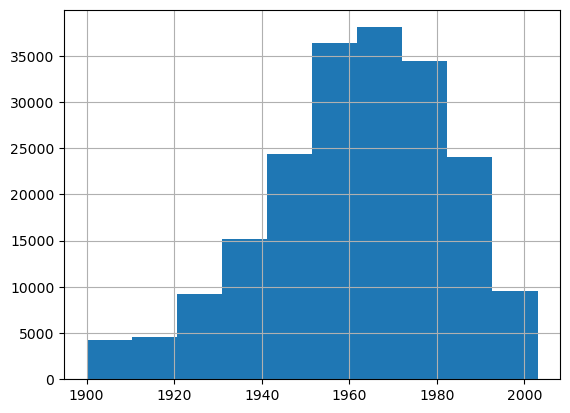

In [16]:
# First lets look at the actual Age distribution
df["YEAROFBIRTH"].hist()

In [39]:
desired_distr = {(1940, 1965): 0.3,
                 (1966, 2020): 0.7}
desired_size = 50_000

In [40]:
def size_possible(df: pd.DataFrame, desired_distr: dict, desired_size: int, attr_name: str, mapping: callable):
    for key, portion in desired_distr.items():
        if round(portion * desired_size) > df[df.apply(lambda row: mapping(key, row[attr_name]), axis=1)].shape[0]:
            return False
    return True

def attr_value_distribution_random_sample(df: pd.DataFrame, desired_distr: dict, desired_size: int, attr_name: str, seed: int=None):
    if isinstance(list(desired_distr.keys())[0], tuple):
        # keys are given as ranges
        mapping = lambda key, value: key[0] <= value <= key[1]
    else:
        mapping = lambda key, value: value == key
        # make sure there are only possible values given
        if not all([key in possible_values for key in desired_distr.keys()]):
            impossible_values = [key for key in desired_distr if key not in possible_values]
            raise ValueError("There is at least one value specified that is not present in the data.\n"
                             f"Impossible value(s): {str(impossible_values)}")
    # make sure the portions add up to one
    if sum(desired_distr.values()) != 1:
        raise ValueError("Portions must add up to 1.")
    # check if the desired size is possible
    if not size_possible(df, desired_distr, desired_size, attr_name, mapping):
        raise ValueError(f"Desired size {desired_size} is not possible to draw with desired distribution.")
    # draw randomly according to the desired distribution
    result_subsets = [random_sample_wrapper(df[df.apply(lambda row: mapping(key, row[attr_name]), axis=1)],
                                            total_sample_size=round(portion*desired_size),
                                            seed=seed)
                      for key, portion in desired_distr.items()]
    # concatenate all and return
    return pd.concat(result_subsets)
# TODO write test cases

In [41]:
result = attr_value_distribution_random_sample(df, desired_distr, desired_size, "YEAROFBIRTH", seed=42)

In [42]:
# check the distribution
observed_distr = {key: result[result.YEAROFBIRTH.map(lambda value: key[0] <= value <= key[1])].shape[0] / result.shape[0]
                  for key in desired_distr}
observed_distr

{(1940, 1965): 0.3, (1966, 2020): 0.7}

In [43]:
split_and_get_overlap(result)

0.22024

#### Observation:
* again, overlap not preserved